# AE 353: Drone Project

*Version: May 2022*

Authors: Grace Heaton and Varsha Krishnakumar

Import modules.

In [1]:
# Standard modules
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import secrets
import sympy as sym
import numpy.linalg as la
from scipy import linalg

# Module from AE 353 class
import ae353_drone
import timeit

Create and print a seed for the random number generator so it is possible to reproduce the results.

In [2]:
seed = secrets.randbits(32)
print(seed)

1942502857


Create simulator with seed.

In [3]:
simulator = ae353_drone.Simulator(
    display=False,    # Set to False for faster data collection
    seed=seed,
)

Set rules on simulator to allow or reject print statements and long runtimes

In [4]:
simulator.set_rules(
    error_on_print=False,    # <-- allow print statements in controller code
    error_on_timeout=True,  # <-- allow long runtimes in controller code
)

### Dynamicand Sensor Model 

Evaluation of function $f$ and $g$

In [5]:
params = {
    'm': 0.5,
    'Jx': 0.0023,
    'Jy': 0.0023,
    'Jz': 0.0040,
    'l': 0.175,
    'g': 9.81,
}

# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# yaw, pitch, roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')
v_in_body = sym.Matrix([v_x, v_y, v_z])

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')
w_in_body = sym.Matrix([w_x, w_y, w_z])

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m = sym.nsimplify(params['m'])
Jx = sym.nsimplify(params['Jx'])
Jy = sym.nsimplify(params['Jy'])
Jz = sym.nsimplify(params['Jz'])
l = sym.nsimplify(params['l'])
g = sym.nsimplify(params['g'])
J = sym.diag(Jx, Jy, Jz)

# rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# applied forces
f_in_body = R_body_in_world.T @ sym.Matrix([[0], [0], [-m * g]]) + sym.Matrix([[0], [0], [f_z]])

# applied torques
tau_in_body = sym.Matrix([[tau_x], [tau_y], [tau_z]])

# equations of motion
f = sym.Matrix.vstack(
    R_body_in_world * v_in_body,
    M * w_in_body,
    (1 / m) * (f_in_body - w_in_body.cross(m * v_in_body)),
    J.inv() * (tau_in_body - w_in_body.cross(J * w_in_body)),
)

f = sym.simplify(f, full=True)
g = sym.Matrix([p_x, p_y, p_z, psi])

In [6]:
f

Matrix([
[v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) - v_z*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))],
[                                                                      -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                                 (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                                                                                              w_y*cos(phi) - w_z*sin(phi)],
[                                                                                  w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[                                                                                                   v_y*w_z - v_z*w_y + 981*sin(theta)/100],
[   

In [7]:
g

Matrix([
[p_x],
[p_y],
[p_z],
[psi]])

Evaluate $x_e$ from the set equilibrium conditions

In [8]:
p_xe, p_ye, p_ze, psie, thetae, phie, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze = np.zeros(16)
f_ze = 981/200

all_eq = np.array([p_xe, p_ye, p_ze, psie, thetae, phie, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze])
xe = all_eq[:12].reshape((12,1))

In [9]:
xe

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

Evaluate $f$ at the equilibrium conditions

In [10]:
f_num = sym.lambdify((p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z),f)
g_num = sym.lambdify((p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z),g)
f_num(p_xe, p_ye, p_ze, psie, thetae, phie, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

It can be seen from above that the set equilibrum point works for $f$

Evaluate $A$, $B$, and $C$ matrices by linearizing the system about the equilibrium points. 

In [11]:
A_num = sym.lambdify((p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z), f.jacobian([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]))
B_num = sym.lambdify((p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z), f.jacobian([tau_x, tau_y, tau_z, f_z]))
C_num = sym.lambdify((p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z), g.jacobian([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]))

A = A_num(p_xe, p_ye, p_ze, psie, thetae, phie, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze)
B = B_num(p_xe, p_ye, p_ze, psie, thetae, phie, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze)
C = C_num(p_xe, p_ye, p_ze, psie, thetae, phie, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze)

In [12]:
A.tolist()

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 9.81, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, -9.81, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

In [13]:
B.tolist()

[[0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 2.0],
 [434.7826086956522, 0.0, 0.0, 0.0],
 [0.0, 434.7826086956522, 0.0, 0.0],
 [0.0, 0.0, 250.0, 0.0]]

In [14]:
C.tolist()

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]

Define the function **lqr** that takes the $A$ and $B$ matrices from above and $Q$ and $R$ matrices generated later in this file

In [15]:
def lqr(A,B,Q,R):
    P=linalg.solve_continuous_are(A,B,Q,R)
    K=linalg.inv(R) @ B.T @ P
    return K

Use the **lqr** function to evaluate $K$ and $L$ matrices

In [16]:
Qc = np.diag([23.,15.,5.,10.,1.05,1.05,5.16487,1., 1., 1., 1., 1.]) 
Rc = np.diag([200.,200.,200.,2.])
K = lqr(A,B,Qc,Rc)

Qo = 500*np.eye(B.shape[1])
Ro = 0.015*np.eye(A.shape[0])

L = lqr(A.T, C.T, linalg.inv(Ro), linalg.inv(Qo)).T

In [17]:
K.tolist()

[[9.678260905581332e-16,
  -0.27386127875258165,
  -9.522812217097916e-18,
  -3.823840594057578e-16,
  1.2171010578564007e-15,
  0.5658020136170426,
  7.039847654220251e-16,
  -0.19128636008222402,
  1.0252604736879788e-17,
  0.08719340148565355,
  1.6793973074714342e-17,
  -8.042016296824187e-17],
 [0.3391164991562657,
  6.899489393202653e-16,
  3.4244885432334127e-17,
  1.2913035381298337e-16,
  0.6849151480169273,
  -2.9885684231733967e-16,
  0.27051295855672947,
  1.8458338137529275e-16,
  -4.557851041410718e-17,
  1.6793973074714342e-17,
  0.09028072707326784,
  -5.911272088148051e-17],
 [-6.998288602736174e-16,
  6.321734240076456e-16,
  1.4117449207385284e-16,
  0.22360679774997907,
  -1.0567837805654919e-15,
  -7.106137843585599e-16,
  -4.4204580663401085e-16,
  1.6924923535887553e-16,
  1.0603285208310663e-16,
  -4.624159370673907e-17,
  -3.398981450685129e-17,
  0.08239450456189329],
 [-5.6395976164965e-16,
  5.331111605434352e-16,
  1.5811388300841909,
  8.37433348946284e-16

In [18]:
L.tolist()

[[188.0006123103706, 0.0, 0.0, 0.0],
 [0.0, 188.0006123103706, 0.0, 0.0],
 [0.0, 0.0, 183.57146212034766, 0.0],
 [0.0, 0.0, 0.0, 183.57146212034766],
 [266.0041202723958, 0.0, 0.0, 0.0],
 [0.0, -266.0041202723958, 0.0, 0.0],
 [1005.4484478716696, 0.0, 0.0, 0.0],
 [0.0, 1005.4484478716696, 0.0, 0.0],
 [0.0, 0.0, 182.57418583505267, 0.0],
 [0.0, -182.5741858350501, 0.0, 0.0],
 [182.5741858350501, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 182.57418583505267]]

Check if system is controllable using the controllability matrix $W$

In [19]:
def is_controllable(A,B):
    '''returns controllability matrix W and True/False for controllability of system'''
    n = A.shape[0]
    W = B
    for i in range(1, n):
        col = np.linalg.matrix_power(A, i) @ B
        W = np.block([W, col])
    return W, np.linalg.matrix_rank(W)==W.shape[0]

W = is_controllable(A,B)[0]
is_controllable(A,B)[1] # will return True if controllable

True

Check if system is observable using the observability matrix $W_o$

In [20]:
def is_observable(A,C):
    n = A.shape[0]
    O = C
    for i in range(1,n):
        row = C@la.matrix_power(A,i)
        O = np.block([[O],[row]])
    return la.matrix_rank(O)==n
is_observable(A,C) # will return True if observable

True

Check if system is stable

In [21]:
def is_stable(A,L,C):
    F = A-L@C
    eigs = la.eigvals(F)
    return (eigs.real<0).all()

is_stable(A,L,C) # will print True if stable

True

Define **rmse** function to evaluate Root Mean-Squared Error between actual and desired position

In [22]:
def rmse(x,xhat):
    return (np.sum((x-xhat)**2)/len(x))**0.5

Define **Controller** class for the drone system

In [23]:
class Controller:
    def __init__(self):
        self.A = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 9.81, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, -9.81, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
        self.B = np.array([[0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 2.0],
 [434.7826086956522, 0.0, 0.0, 0.0],
 [0.0, 434.7826086956522, 0.0, 0.0],
 [0.0, 0.0, 250.0, 0.0]])
        self.C = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])
        self.K = np.array([[9.678260905581332e-16,
  -0.27386127875258165,
  -9.522812217097916e-18,
  -3.823840594057578e-16,
  1.2171010578564007e-15,
  0.5658020136170426,
  7.039847654220251e-16,
  -0.19128636008222402,
  1.0252604736879788e-17,
  0.08719340148565355,
  1.6793973074714342e-17,
  -8.042016296824187e-17],
 [0.3391164991562657,
  6.899489393202653e-16,
  3.4244885432334127e-17,
  1.2913035381298337e-16,
  0.6849151480169273,
  -2.9885684231733967e-16,
  0.27051295855672947,
  1.8458338137529275e-16,
  -4.557851041410718e-17,
  1.6793973074714342e-17,
  0.09028072707326784,
  -5.911272088148051e-17],
 [-6.998288602736174e-16,
  6.321734240076456e-16,
  1.4117449207385284e-16,
  0.22360679774997907,
  -1.0567837805654919e-15,
  -7.106137843585599e-16,
  -4.4204580663401085e-16,
  1.6924923535887553e-16,
  1.0603285208310663e-16,
  -4.624159370673907e-17,
  -3.398981450685129e-17,
  0.08239450456189329],
 [-5.6395976164965e-16,
  5.331111605434352e-16,
  1.5811388300841909,
  8.37433348946284e-16,
  -6.826748044301405e-16,
  1.4680159093020057e-16,
  -3.679083849918678e-16,
  -4.190927950808831e-18,
  1.4426152744526837,
  4.716198178964702e-18,
  -2.09661147904893e-17,
  8.482628166648531e-17]])
        self.L = np.array([[188.0006123103706, 0.0, 0.0, 0.0],
 [0.0, 188.0006123103706, 0.0, 0.0],
 [0.0, 0.0, 183.57146212034766, 0.0],
 [0.0, 0.0, 0.0, 183.57146212034766],
 [266.0041202723958, 0.0, 0.0, 0.0],
 [0.0, -266.0041202723958, 0.0, 0.0],
 [1005.4484478716696, 0.0, 0.0, 0.0],
 [0.0, 1005.4484478716696, 0.0, 0.0],
 [0.0, 0.0, 182.57418583505267, 0.0],
 [0.0, -182.5741858350501, 0.0, 0.0],
 [182.5741858350501, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 182.57418583505267]])  
        self.p_xe = 0.
        self.p_ye = 0.
        self.p_ze = 0.
        
        self.tau_xe = 0.
        self.tau_ye = 0.
        self.tau_ze = 0.
        self.f_ze = 4.905
        self.xe = np.array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])
        self.dt = 0.01
        
        self.p_desired = np.zeros(3)
        self.variables_to_log = ['p_desired']

    def get_color(self):
        return [0., 1., 0.]
    

    def reset(
            self,
            p_x_meas, p_y_meas, p_z_meas, # <-- measured position of drone (meters)
            yaw_meas,                     # <-- measured yaw angle of drone (radians)
        ):
        
        self.xhat = np.array([p_x_meas, p_y_meas, p_z_meas, 0, 0, 0, 0, 0, 0, 0, 0, 0]).reshape(12,1)
        

    def run(
            self,
            p_x_meas, p_y_meas, p_z_meas, # <-- measured position of drone (meters)
            yaw_meas,                     # <-- measured yaw angle of drone (radians)
            p_x_ring, p_y_ring, p_z_ring, # <-- center position of next ring (meters)
            is_last_ring,                 # <-- True if next ring is the last ring, False otherwise
            pos_others,                   # <-- 2d array of size n x 3, where n is the number
                                          #     of all *other* drones - the ith row in this array
                                          #     has the coordinates [x_i, y_i, z_i], in meters, of
                                          #     the ith other drone
        ):
        

        x_meas = np.array([p_x_meas, p_y_meas, p_z_meas, yaw_meas, 0, 0, 0, 0, 0, 0, 0, 0]).reshape((12,1)) # measured state (partial)
        x_des = np.array([p_x_ring, p_y_ring, p_z_ring, 0, 0, 0, 0, 0, 0, 0, 0, 0]).reshape(12,1) # desired state estimate
        
        # Position Tracking
        
        p_hat = self.xhat[0:3]
        p_ring = np.array([p_x_ring, p_y_ring, p_z_ring]).reshape(3, 1)
        p_err = p_ring - p_hat
        
        # Collision Avoidance: Repuslive Potential
        r_drone = 0.41
        p_goal = p_ring
        hatt_grad = (p_hat - p_goal) / linalg.norm(p_hat - p_goal)
        hrep_grad = np.zeros(3)
        for q in pos_others:
            d = linalg.norm(p_hat - q) - (r_drone + r_drone)
            dgrad = (p_hat - q) / d
            hrep_grad += - 0.20*(1 / d**2) * dgrad
        p_des = p_hat - (hatt_grad*hrep_grad)
        
        r = 2.1
        if(linalg.norm(p_err)>0.01):
            p_norm = p_err/(linalg.norm(p_err)) 
            p_des = p_hat + r*p_norm

        else:
            p_des = p_ring
                
        x_des[0] = p_des[0]
        x_des[1] = p_des[1]
        x_des[2] = p_des[2]
        
            
        # Sensor Model
        u_des = np.array([self.tau_xe, self.tau_ye, self.tau_ze, -self.f_ze])
        u = u_des - self.K@(self.xhat - x_des)

        u = -self.K@(self.xhat-x_des)
        y = (self.C @ (x_meas - self.xe)).reshape(4,1)
        
        tau_x = u[0,0] + self.tau_xe
        tau_y = u[1,0] + self.tau_ye
        tau_z = u[2,0] + self.tau_ze
        
        if y[2,0] <= 0.5:
            u[3,0] = 3.2

        if is_last_ring: 
            if abs(p_ring[0] - p_x_meas) < 0.695 and abs(p_ring[1] - p_y_meas) < 0.695:
                u[3,0] = -110.
                
        f_z = u[3,0] + self.f_ze

        self.xhat += self.dt*((self.A @ self.xhat) + (self.B @ u) - (self.L @ ((self.C @ self.xhat) - y)))
        
        
        self.p_desired = x_des[:3]
        
        return tau_x, tau_y, tau_z, f_z

### Perform One Simulation

Clear drones in current simulation

In [24]:
simulator.clear_drones()

Add the drone to the simulator. There are three arguments:

* `Controller` is the class definition
* `'varshak3'` is the name of the drone
* `'droneface.png'` is the name of an image to use as a label (can be `None`, can be a file path)

This function can be called than once, as long as it is called with a different drone name each time. An exception will be raised if there are more than one drone of the same name added to the simulator.

In [25]:
simulator.add_drone(Controller, 'varshak3', 'droneface.png')

Zoom the camera closer to the drone

In [26]:
simulator.camera_droneview('varshak3')

Reset the drone (i.e., place it at a random location in the start ring).

In [27]:
simulator.reset()

Run simulation until `max_time` is reached or until the drone reaches the finish ring.

In [28]:
simulator.run(max_time=None)

FINISHED: drone "varshak3" at time 16.44


Get result.

In [29]:
(
    did_it_fail,
    did_it_finish,
    what_time_did_it_finish,
    
) = simulator.get_result('varshak3')

Show result.

In [30]:
if did_it_fail:
    print('The drone failed before finishing.')
elif did_it_finish:
    print(f'The drone finished at time {what_time_did_it_finish}')
else:
    print('The drone did not finish (yet).')

The drone finished at time 16.44


Get data.

In [33]:
num_iters = 1000
finished = 0
failed = 0
finish_times = np.zeros(num_iters)

exec_time  = []
max_exec_time = []
avg_exec_time = []

rmse_contr = []
rmse_contr_x = []
rmse_contr_y = []
rmse_contr_z = []

rmse_obsv = []
rmse_obsv_x = []
rmse_obsv_y = []
rmse_obsv_z = []

for i in range(num_iters):
    simulator.clear_drones()
    simulator.add_drone(Controller, 'varshak3', 'droneface.png')
    simulator.move_rings()
    simulator.reset()
    simulator.set_rules(error_on_print=True,    error_on_timeout=True,)
    simulator.run(max_time=40.0)
    drone = simulator.get_drone_by_name('varshak3')
    data = simulator.get_data('varshak3')
    if drone['finish_time'] is None:
        failed += 1
    else:
        finished += 1
        finish_times[i] = drone['finish_time']
    if i%10 == 0:
        print(f"{i} /", num_iters)
    #print(i, " /", num_iters)
    
    
    # Controller Data
    #rmse_contr_x.append(rmse(data['p_x'],data['p_desired'][:,0]))
    #rmse_contr_y.append(rmse(data['p_y'],data['p_desired'][:,1]))
    #rmse_contr_z.append(rmse(data['p_z'],data['p_desired'][:,2]))
    
    p = np.array([data['p_x'], data['p_y'], data['p_z']]).T
    p_hat = np.array([data['p_x_meas'],data['p_y_meas'],data['p_z_meas']]).T
    # Use these lines if you want to compare how close new position is to the last desired position
    rmse_contr.append(rmse(p,data['p_desired']))
    rmse_contr_x.append(rmse(data['p_x'][1:],data['p_desired'][:-1,0]))
    rmse_contr_y.append(rmse(data['p_y'][1:],data['p_desired'][:-1,1]))
    rmse_contr_z.append(rmse(data['p_z'][1:],data['p_desired'][:-1,2]))
    
    # Observer data
    rmse_obsv.append(rmse(p, p_hat))
    rmse_obsv_x.append(rmse(data['p_x'],data['p_x_meas']))
    rmse_obsv_y.append(rmse(data['p_y'],data['p_y_meas']))
    rmse_obsv_z.append(rmse(data['p_z'],data['p_z_meas']))
    
    # Runtime data
    exec_time.append(data['run_time'])
    max_exec_time.append(max(data['run_time']))
    avg_exec_time.append(np.mean(data['run_time']))
    
print(num_iters, f" /", num_iters)


FINISHED: drone "varshak3" at time 15.95
0 / 1000
FINISHED: drone "varshak3" at time 21.66
FINISHED: drone "varshak3" at time 22.83
FINISHED: drone "varshak3" at time 15.85
FINISHED: drone "varshak3" at time 14.24
FINISHED: drone "varshak3" at time 17.24
FINISHED: drone "varshak3" at time 16.41
FINISHED: drone "varshak3" at time 16.33
FINISHED: drone "varshak3" at time 17.25
10 / 1000
FINISHED: drone "varshak3" at time 15.78
FINISHED: drone "varshak3" at time 15.92
FINISHED: drone "varshak3" at time 15.03
FINISHED: drone "varshak3" at time 16.50

error on run of drone varshak3 (turning it off):
Traceback (most recent call last):
  File "C:\Users\HP\Documents\GitHub\04_drone\ae353_drone.py", line 791, in step
    raise Exception(f'Run timeout exceeded: {controller_run_time} > {self.max_controller_run_time}')
Exception: Run timeout exceeded: 0.05800580978393555 > 0.005

FINISHED: drone "varshak3" at time 15.74
FINISHED: drone "varshak3" at time 16.59
20 / 1000
FINISHED: drone "varshak3" 

FINISHED: drone "varshak3" at time 16.55
180 / 1000
FINISHED: drone "varshak3" at time 16.88
FINISHED: drone "varshak3" at time 19.93
FINISHED: drone "varshak3" at time 16.37

error on run of drone varshak3 (turning it off):
Traceback (most recent call last):
  File "C:\Users\HP\Documents\GitHub\04_drone\ae353_drone.py", line 791, in step
    raise Exception(f'Run timeout exceeded: {controller_run_time} > {self.max_controller_run_time}')
Exception: Run timeout exceeded: 0.05600762367248535 > 0.005

FINISHED: drone "varshak3" at time 14.40
FINISHED: drone "varshak3" at time 15.18
FINISHED: drone "varshak3" at time 17.47
FINISHED: drone "varshak3" at time 15.03
FINISHED: drone "varshak3" at time 16.46
190 / 1000
FINISHED: drone "varshak3" at time 14.10
FINISHED: drone "varshak3" at time 15.08
FINISHED: drone "varshak3" at time 18.48
FINISHED: drone "varshak3" at time 17.41
FINISHED: drone "varshak3" at time 15.99
FINISHED: drone "varshak3" at time 18.06
FINISHED: drone "varshak3" at time

FINISHED: drone "varshak3" at time 16.96
FINISHED: drone "varshak3" at time 14.81
FINISHED: drone "varshak3" at time 13.39
FINISHED: drone "varshak3" at time 17.99
360 / 1000

error on run of drone varshak3 (turning it off):
Traceback (most recent call last):
  File "C:\Users\HP\Documents\GitHub\04_drone\ae353_drone.py", line 791, in step
    raise Exception(f'Run timeout exceeded: {controller_run_time} > {self.max_controller_run_time}')
Exception: Run timeout exceeded: 0.005003690719604492 > 0.005

FINISHED: drone "varshak3" at time 15.04
FINISHED: drone "varshak3" at time 14.25

error on run of drone varshak3 (turning it off):
Traceback (most recent call last):
  File "C:\Users\HP\Documents\GitHub\04_drone\ae353_drone.py", line 791, in step
    raise Exception(f'Run timeout exceeded: {controller_run_time} > {self.max_controller_run_time}')
Exception: Run timeout exceeded: 0.06021714210510254 > 0.005

FINISHED: drone "varshak3" at time 16.41
FINISHED: drone "varshak3" at time 19.95
37

FINISHED: drone "varshak3" at time 18.48
FINISHED: drone "varshak3" at time 17.59
FINISHED: drone "varshak3" at time 19.10
FINISHED: drone "varshak3" at time 13.49
540 / 1000
FINISHED: drone "varshak3" at time 15.74
FINISHED: drone "varshak3" at time 15.46
FINISHED: drone "varshak3" at time 16.78
FINISHED: drone "varshak3" at time 22.44
FINISHED: drone "varshak3" at time 14.07
FINISHED: drone "varshak3" at time 15.34
FINISHED: drone "varshak3" at time 15.46
FINISHED: drone "varshak3" at time 13.27
FINISHED: drone "varshak3" at time 15.90

error on run of drone varshak3 (turning it off):
Traceback (most recent call last):
  File "C:\Users\HP\Documents\GitHub\04_drone\ae353_drone.py", line 791, in step
    raise Exception(f'Run timeout exceeded: {controller_run_time} > {self.max_controller_run_time}')
Exception: Run timeout exceeded: 0.06917405128479004 > 0.005

550 / 1000
FINISHED: drone "varshak3" at time 16.90
FINISHED: drone "varshak3" at time 13.01
FINISHED: drone "varshak3" at time

FINISHED: drone "varshak3" at time 16.00
FINISHED: drone "varshak3" at time 13.62
730 / 1000
FINISHED: drone "varshak3" at time 16.75
FINISHED: drone "varshak3" at time 20.23
FINISHED: drone "varshak3" at time 20.08
FINISHED: drone "varshak3" at time 16.68
FINISHED: drone "varshak3" at time 16.92
FINISHED: drone "varshak3" at time 15.47
FINISHED: drone "varshak3" at time 14.87
FINISHED: drone "varshak3" at time 17.18
FINISHED: drone "varshak3" at time 19.59
740 / 1000

error on run of drone varshak3 (turning it off):
Traceback (most recent call last):
  File "C:\Users\HP\Documents\GitHub\04_drone\ae353_drone.py", line 791, in step
    raise Exception(f'Run timeout exceeded: {controller_run_time} > {self.max_controller_run_time}')
Exception: Run timeout exceeded: 0.06608366966247559 > 0.005

FINISHED: drone "varshak3" at time 16.26
FINISHED: drone "varshak3" at time 14.64
FINISHED: drone "varshak3" at time 13.43
FINISHED: drone "varshak3" at time 17.05
FINISHED: drone "varshak3" at time

FINISHED: drone "varshak3" at time 18.24
FINISHED: drone "varshak3" at time 15.34
FINISHED: drone "varshak3" at time 16.00
FINISHED: drone "varshak3" at time 14.08
FINISHED: drone "varshak3" at time 14.57
FINISHED: drone "varshak3" at time 20.43
FINISHED: drone "varshak3" at time 15.35
FINISHED: drone "varshak3" at time 20.49
FINISHED: drone "varshak3" at time 19.52
910 / 1000
FINISHED: drone "varshak3" at time 27.32
FINISHED: drone "varshak3" at time 20.13
FINISHED: drone "varshak3" at time 17.51
FINISHED: drone "varshak3" at time 17.99
FINISHED: drone "varshak3" at time 15.72
FINISHED: drone "varshak3" at time 16.59
FINISHED: drone "varshak3" at time 16.09
FINISHED: drone "varshak3" at time 20.55
FINISHED: drone "varshak3" at time 14.37
920 / 1000
FINISHED: drone "varshak3" at time 15.69
FINISHED: drone "varshak3" at time 18.67
FINISHED: drone "varshak3" at time 14.66
FINISHED: drone "varshak3" at time 16.48
FINISHED: drone "varshak3" at time 19.79
FINISHED: drone "varshak3" at time 

In [34]:
final_finish_times = []
for i in range(len(finish_times)):
    if finish_times[i] >= 0:
         final_finish_times.append(finish_times[i])
final_finish_times = np.asarray(final_finish_times)

Obtain statistics

In [35]:
print(f"Total number of runs:  ", num_iters)
print(f"No. of successful runs:", finished)
print(f"No. of failed runs:    ", failed)
print(f"Success rate:          ", finished/num_iters * 100)
print(f"Mean finish time:      ", np.mean(final_finish_times))
print(f"Median finish time:    ",np.median(final_finish_times))
print(f"Standard Deviation     ", np.std(final_finish_times))
print(f"Fastest Time:    ", np.min(final_finish_times))
print(f"Slowest Time:    ", np.max(final_finish_times))

Total number of runs:   1000
No. of successful runs: 849
No. of failed runs:     151
Success rate:           84.89999999999999
Mean finish time:       17.172767962308598
Median finish time:     16.85
Standard Deviation      2.343724044608809
Fastest Time:     12.790000000000001
Slowest Time:     28.080000000000002


Plot results.

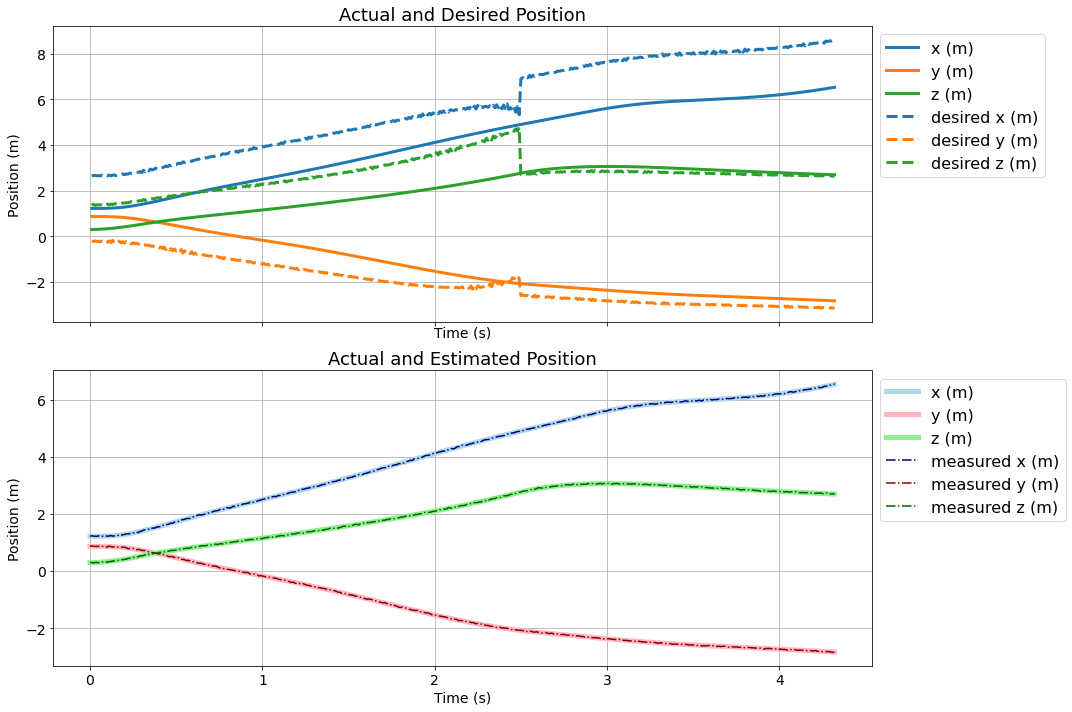

In [37]:
# Create a figure with subplots that all share the same x-axis
fig, (ax_cont, ax_obsv) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)


# Controller
ax_cont.plot(data['t'][1:], data['p_x'][1:], label='x (m)', linewidth=3, color='C0')
ax_cont.plot(data['t'][1:], data['p_y'][1:], label='y (m)', linewidth=3, color='C1')
ax_cont.plot(data['t'][1:], data['p_z'][1:], label='z (m)', linewidth=3, color='C2')
ax_cont.plot(data['t'][1:], data['p_desired'][:-1,0], '--', label='desired x (m)', linewidth=3, color='C0')
ax_cont.plot(data['t'][1:], data['p_desired'][:-1,1], '--', label='desired y (m)', linewidth=3, color='C1')
ax_cont.plot(data['t'][1:], data['p_desired'][:-1,2], '--', label='desired z (m)', linewidth=3, color='C2')
ax_cont.set_title('Actual and Desired Position', fontsize=18)
ax_cont.set_xlabel('Time (s)', fontsize=14)
ax_cont.set_ylabel('Position (m)', fontsize=14)
ax_cont.grid()
ax_cont.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_cont.tick_params(labelsize=14)

# Observer
ax_obsv.plot(data['t'], data['p_x'], label='x (m)', linewidth=5, color='lightblue')
ax_obsv.plot(data['t'], data['p_y'], label='y (m)', linewidth=5, color='lightpink')
ax_obsv.plot(data['t'], data['p_z'], label='z (m)', linewidth=5, color='lightgreen')
ax_obsv.plot(data['t'], data['p_x_meas'], '-.', label='measured x (m)', markersize=7, color='navy')
ax_obsv.plot(data['t'], data['p_y_meas'], '-.', label='measured y (m)', markersize=7, color='darkred')
ax_obsv.plot(data['t'], data['p_z_meas'], '-.', label='measured z (m)', markersize=7, color='darkgreen')
ax_obsv.set_title('Actual and Estimated Position', fontsize=18)
ax_obsv.set_xlabel('Time (s)', fontsize=14)
ax_obsv.set_ylabel('Position (m)', fontsize=14)
ax_obsv.grid()
ax_obsv.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_obsv.tick_params(labelsize=14)

# Make the arrangement of subplots look nice
fig.tight_layout()
plt.show()
fig.savefig('compare_to_actual.png')

Save the figure (without transparent background).

In [38]:
fig.savefig('resultplot.png', facecolor='white', transparent=False)
max(rmse_obsv_y)
avg_exec_time
max_exec_time
len(exec_time)
exec_time = (np.concatenate( exec_time, axis=0 )).tolist()

Check which simulations exceeded a runtime of 0.01

In [39]:
def num_greater(array, val):
    sum = 0
    for i in range(len(array)):
        if array[i]>val:
            sum+=1
    return sum

num_greater(exec_time, 0.01),len(exec_time)
np.mean(exec_time)*1e3
np.mean(avg_exec_time)
np.mean(max_exec_time), max(max_exec_time)

num_greater(exec_time, 0.01),len(exec_time)

(0, 2002129)

# Aggregate Data Analysis

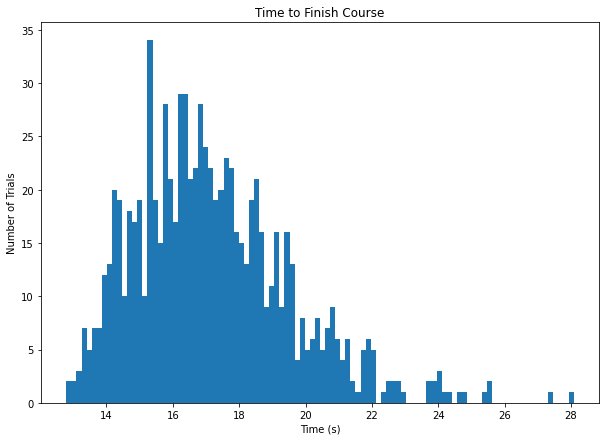

In [42]:
# Completion Time Histogram
fig, (ax_time) = plt.subplots(1,figsize=(10, 7))

ax_time.hist(final_finish_times, bins= 100)
ax_time.set_xlabel("Time (s)")
ax_time.set_ylabel("Number of Trials")
ax_time.set_title("Time to Finish Course")

avg_time = np.mean(final_finish_times)
#ax_time.vlines(avg_time, 0,40, linewidth = 3, color='red', label=f"Avg = {np.round(avg_time,2)} seconds")
#ax_time.legend()
plt.show()
fig.savefig('drone_times.png')

Plot histogram of controller run times.

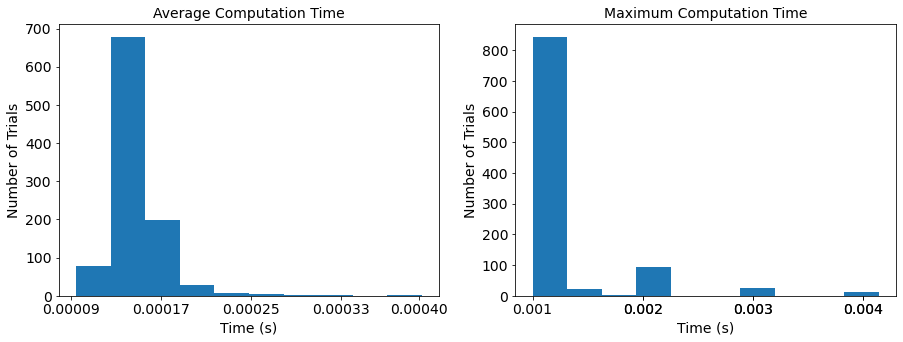

In [43]:

# Side by side option (runtime and rmse)

fig, (ax_avg,ax_max) = plt.subplots(1, 2, figsize=(15, 5))

ax_avg.hist(avg_exec_time, 10)
ax_avg.tick_params(labelsize=14)
ax_avg.set_title('Average Computation Time', fontsize = 14)
ax_avg.set_ylabel('Number of Trials', fontsize = 14)
ax_avg.set_xlabel('Time (s)', fontsize = 14)
ax_avg.set_xticks(np.round(np.linspace(min(avg_exec_time), max(avg_exec_time),5),5))
#ax_avg.vlines(np.mean(avg_exec_time),0,400, linewidth=3,color='red',label=f"Avg = {np.round(np.mean(avg_exec_time),6)} seconds")
#ax_avg.legend()

ax_max.hist(max_exec_time, 10)
ax_max.tick_params(labelsize=14)
ax_max.set_ylabel('Number of Trials', fontsize = 14)
ax_max.set_xlabel('Time (s)', fontsize = 14)
ax_max.set_title('Maximum Computation Time', fontsize = 14)
ax_max.set_xticks(np.round(np.linspace(min(max_exec_time), max(max_exec_time),7),3))

fig.savefig('comp_time_plots.png')

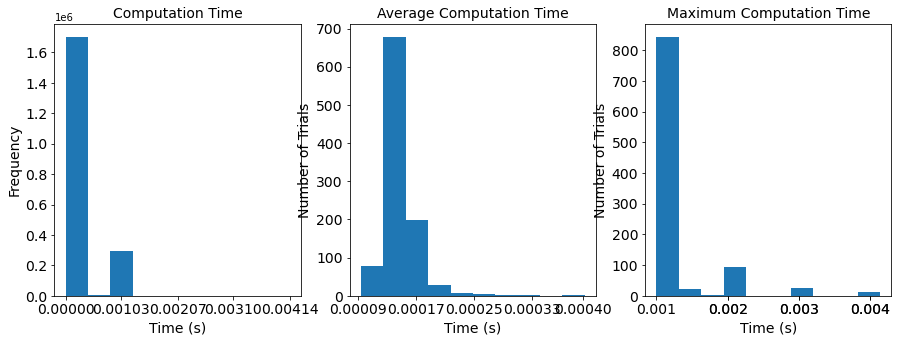

In [44]:
# Average and Max Computation Histogram

fig, (ax_all, ax_avg,ax_max) = plt.subplots(1, 3, figsize=(15, 5))

ax_all.hist(exec_time, 10)
ax_all.tick_params(labelsize=14)
ax_all.set_title('Computation Time', fontsize = 14)
ax_all.set_ylabel('Frequency', fontsize = 14)
ax_all.set_xlabel('Time (s)', fontsize = 14)
ax_all.set_xticks(np.round(np.linspace(min(exec_time), max(exec_time),5),5))

ax_avg.hist(avg_exec_time, 10)
ax_avg.tick_params(labelsize=14)
ax_avg.set_title('Average Computation Time', fontsize = 14)
ax_avg.set_ylabel('Number of Trials', fontsize = 14)
ax_avg.set_xlabel('Time (s)', fontsize = 14)
ax_avg.set_xticks(np.round(np.linspace(min(avg_exec_time), max(avg_exec_time),5),5))

ax_max.hist(max_exec_time, 10)
ax_max.tick_params(labelsize=14)
ax_max.set_ylabel('Number of Trials', fontsize = 14)
ax_max.set_xlabel('Time (s)', fontsize = 14)
ax_max.set_title('Maximum Computation Time', fontsize = 14)
ax_max.set_xticks(np.round(np.linspace(min(max_exec_time), max(max_exec_time),7),3))
fig.savefig('comp_time_plots_3.png')

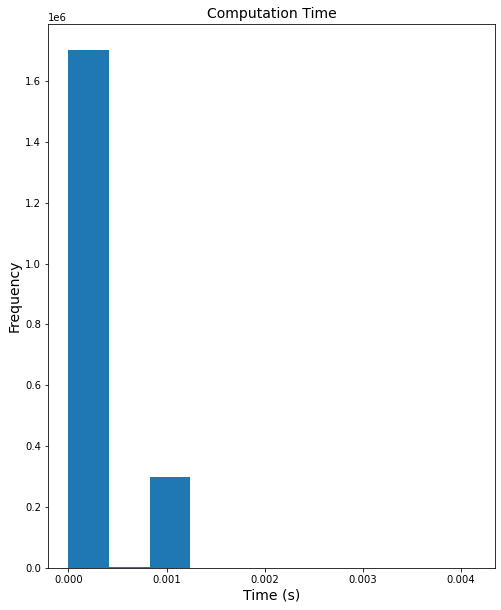

In [45]:
# All computation time histogram
fig, (ax_all) = plt.subplots(1, figsize=(8, 10))
#ax_all.hist(data['run_time'])
ax_all.hist(exec_time)
#ax_all.tick_params(labelsize=14)
ax_all.set_title('Computation Time', fontsize = 14)
ax_all.set_ylabel('Frequency', fontsize = 14)
ax_all.set_xlabel('Time (s)', fontsize = 14)
#ax_all.set_xticks(np.round(np.linspace(min(exec_time), max(exec_time),5),5))
#ax_all.set_yticks(np.linspace(0,2e6,6))
fig.savefig('comp_time_all')

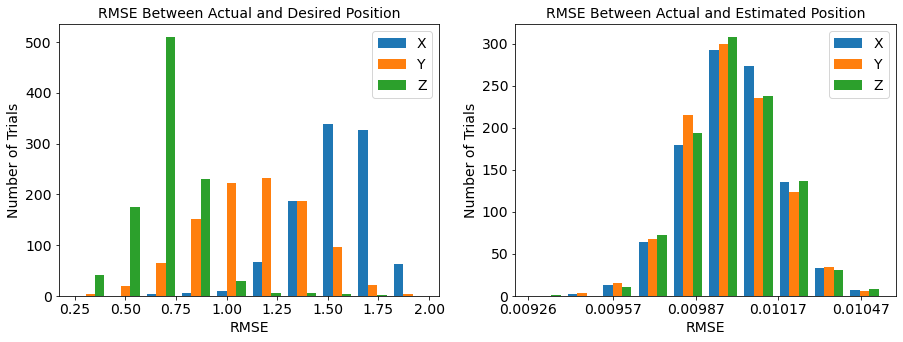

In [46]:
# RMSE histogram

fig, (ax_contr,ax_obsv) = plt.subplots(1, 2, figsize=(15, 5))

ax_contr.hist([rmse_contr_x,rmse_contr_y,rmse_contr_z], 10, label = ['X','Y','Z'])
#ax_contr.set_xticks(np.arange(0, max(max_times), step=50))
ax_contr.tick_params(labelsize=14)
ax_contr.set_title('RMSE Between Actual and Desired Position', fontsize = 14)
ax_contr.set_ylabel('Number of Trials', fontsize = 14)
ax_contr.set_xlabel('RMSE', fontsize = 14)
ax_contr.legend(loc='upper right', fontsize = 14)

ax_obsv.hist([rmse_obsv_x,rmse_obsv_y,rmse_obsv_z], 10, label = ['X','Y','Z'])
ax_obsv.tick_params(labelsize=14)
ax_obsv.set_xticks(np.linspace(min(rmse_obsv_y), max(rmse_obsv_y),5))
#ax_obsv.set_xticks(np.arange(0.009,0.012,0.01))
ax_obsv.set_ylabel('Number of Trials', fontsize = 14)
ax_obsv.set_xlabel('RMSE', fontsize = 14)
ax_obsv.set_xticks(np.round(np.linspace(min(rmse_obsv_z), max(rmse_obsv_z),5),5))
ax_obsv.set_title('RMSE Between Actual and Estimated Position', fontsize = 14)
ax_obsv.legend(loc='upper right', fontsize = 14)
fig.savefig('rmse_plots.png')